# 1. Installing and Importing Dependencies

In [1]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import requests
from bs4 import BeautifulSoup
import re

In [2]:
import numpy as np
import pandas as pd

# 2. Instantiating Model

In [4]:
tokenizer = AutoTokenizer.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

model = AutoModelForSequenceClassification.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

/Users/ayseljafarova/anaconda3/envs/newenv/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


# 3. Encoding and Calculating random Sentiment

In [5]:
tokens = tokenizer.encode('It was good but couldve been better. Great', return_tensors='pt')

In [6]:
result = model(tokens)

In [5]:
result.logits

tensor([[-2.7768, -1.2353,  1.4419,  1.9804,  0.4584]],
       grad_fn=<AddmmBackward0>)

In [6]:
int(torch.argmax(result.logits))+1

4

# 4. Collecting Reviews from Trustpilot

In [8]:
urls = ["https://www.trustpilot.com/review/www.dugood.org",
       "https://www.trustpilot.com/review/www.dugood.org?page=2",
       "https://www.trustpilot.com/review/www.dugood.org?page=3",
       "https://www.trustpilot.com/review/www.dugood.org?page=4",
       "https://www.trustpilot.com/review/www.dugood.org?page=5",
       "https://www.trustpilot.com/review/www.dugood.org?page=6",
       "https://www.trustpilot.com/review/www.dugood.org?page=7",
       "https://www.trustpilot.com/review/www.dugood.org?page=8",
       "https://www.trustpilot.com/review/www.dugood.org?page=9",
       "https://www.trustpilot.com/review/www.dugood.org?page=10",
       "https://www.trustpilot.com/review/www.dugood.org?page=11",
       "https://www.trustpilot.com/review/www.dugood.org?page=12",
       "https://www.trustpilot.com/review/www.dugood.org?page=13",
       "https://www.trustpilot.com/review/www.dugood.org?page=14",
       "https://www.trustpilot.com/review/www.dugood.org?page=15",

       "https://www.trustpilot.com/review/www.dugood.org?page=16",
       "https://www.trustpilot.com/review/www.dugood.org?page=17",
       "https://www.trustpilot.com/review/www.dugood.org?page=18",
       "https://www.trustpilot.com/review/www.dugood.org?page=19",
       "https://www.trustpilot.com/review/www.dugood.org?page=20",
       "https://www.trustpilot.com/review/www.dugood.org?page=21",
       "https://www.trustpilot.com/review/www.dugood.org?page=22",
       "https://www.trustpilot.com/review/www.dugood.org?page=23",
       "https://www.trustpilot.com/review/www.dugood.org?page=24",
       "https://www.trustpilot.com/review/www.dugood.org?page=25"]
reviews =[]

for url in urls: 
    r = requests.get(url)
    soup = BeautifulSoup(r.text, 'html.parser')
    regex = re.compile('.*typography_color-black__5LYEn.*')
    results = soup.find_all('p', {'class':regex})
    review = [result.text for result in results]
    reviews.append(review)

#### Converting reviews list of list to a single list

In [28]:
reviews_single = [review for sublist in reviews for review in sublist]
reviews_single[:30]

['The customer service was amazing. The loan officer Allison Medina was exceptional and would recommend her to anyone. I have had other credit unions but this one beats them all. We were at Rave but gladly switched to here. Great service and awesome credit union and the employees that work here.',
 'I applied for an auto refinancing loan and it was processed the same day. Tracy at the Beaumont Eastex Freeway location was walked me through the process and was extremely helpful, friendly and professional. I couldn’t have been more pleased. ',
 'I financed my car through DuGood and I needed to have a account through them. Decided switching banks was easier then having multiple accounts open. Talked with Christy and she was very nice and helpful. She walked me through the whole process and explained everything in a simple and easy way to understand. I got more benefits then I did with my other bank and staff was so much nicer. Thank you Christy! Would recommend doing business here if you n

# 5. Loading Reviews into DataFrame and Scoring

In [10]:
df = pd.DataFrame(np.array(reviews_single), columns=['review'])

In [80]:
df['review'].iloc[2]

'I financed my car through DuGood and I needed to have a account through them. Decided switching banks was easier then having multiple accounts open. Talked with Christy and she was very nice and helpful. She walked me through the whole process and explained everything in a simple and easy way to understand. I got more benefits then I did with my other bank and staff was so much nicer. Thank you Christy! Would recommend doing business here if you need a good bank!'

#### Creating a function for sentiment calculation

In [11]:
def sentiment_score(review):
    tokens = tokenizer.encode(review, return_tensors='pt')
    result = model(tokens)
    return int(torch.argmax(result.logits))+1

In [82]:
sentiment_score(df['review'].iloc[1])

4

#### Calculating sentiment score of each reiew and loading newly created sentiments to the dataframe

In [13]:
df['sentiment'] = df['review'].apply(lambda x: sentiment_score(x[:512]))

In [14]:
df['sentiment'].iloc[56]

4

## We have a dataframe of 421 Reviews with their Sentiment Predictions 

In [15]:
df.shape

(421, 2)

In [16]:
df.head()

,review,sentiment
0,The customer service was amazing. The loan off...,5
1,I applied for an auto refinancing loan and it ...,4
2,I financed my car through DuGood and I needed ...,5
3,I was helped by an employee named Jada Needham...,4
4,My house is going to be back in the morning an...,3


In [22]:
df.sentiment.value_counts(normalize=True)*100

sentiment
5    87.173397
4     8.788599
3     2.375297
1     1.187648
2     0.475059
Name: proportion, dtype: float64

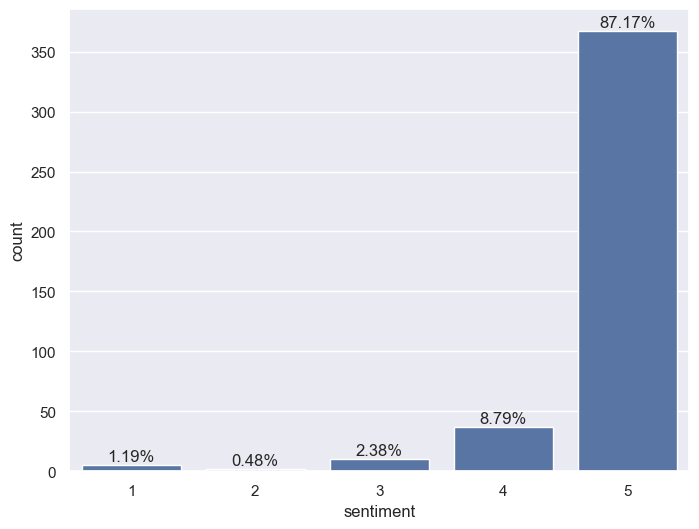

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

# Calculate the percentages for each category
total = float(len(df))  

plt.figure(figsize=(8, 6))
ax = sns.countplot(x='sentiment', data=df)  

# Iterate through each bar's height and add the percentage
for p in ax.patches:
    height = p.get_height()  
    ax.text(p.get_x() + p.get_width() / 2., height+3, '{:.2%}'.format(height/total), ha="center")

plt.show()